# Drug Classification

## Problem statement

- The increasing complexity of the drug landscape has made it **difficult to classify** drugs accurately, leading to confusion and potential risks for patients. 

- This has a **direct impact on patient safety**, as the improper use of medications can lead to adverse events. Furthermore, the lack of unified drug classification makes prescribing, dispensing, and monitoring of drug therapies difficult for healthcare professionals. 

- As such, it is **essential to develop a comprehensive drug classification system** that is both accurate and standardized. Such a system should include age, gender, BP levels, Cholesterol levels, Sodium to potassium ratio to ensure that healthcare professionals are **accurately prescribing and monitoring medications**.

- Additionally, such a **system should be tailored to the specific needs of the patient** and should be easily accessible to both healthcare professionals and patients.


## Data description 

- **Age** - age of person
- **Sex** - male or female
- **Blood Pressure Levels (BP)** - BP of person
- **Cholesterol Levels** - cholesterol of person
- **Na to Potassium Ration** - Sodium to potassium Ration in Blood
- **Drug** - drug type

## Importing libraries

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, classification_report, ConfusionMatrixDisplay                                             
from sklearn.naive_bayes import GaussianNB                         
from imblearn.over_sampling import SMOTE 


import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [78]:
df=pd.read_parquet('../data/drug200.parquet')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [79]:
df.shape

(200, 6)

In [80]:
df.drop(df[df.Drug=='drugC'].index,inplace=True)

In [81]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
5,22,F,NORMAL,HIGH,8.607,drugX
6,49,F,NORMAL,HIGH,16.275,DrugY


In [82]:
df.shape

(184, 6)

In [83]:
df['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugB    16
Name: Drug, dtype: int64

In [84]:
update1=(df["Drug"]=='drugA')
update2=(df["Drug"]=='drugB')

In [85]:
df.loc[update1,'Drug']='DrugY'
df.loc[update2,'Drug']='drugX'

In [86]:
df.shape

(184, 6)

In [87]:
df['Drug'].value_counts()

DrugY    114
drugX     70
Name: Drug, dtype: int64

## Exploratory Data Analysis 

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          184 non-null    int64  
 1   Sex          184 non-null    object 
 2   BP           184 non-null    object 
 3   Cholesterol  184 non-null    object 
 4   Na_to_K      184 non-null    float64
 5   Drug         184 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.1+ KB


In [89]:
df.describe()

,Age,Na_to_K
count,184.000000,184.000000
mean,44.472826,16.558462
std,16.565133,7.319965
min,15.000000,6.269000
25%,31.000000,10.883500
50%,44.000000,14.440500
75%,58.000000,20.132000
max,74.000000,38.247000


<AxesSubplot:xlabel='Sex', ylabel='count'>

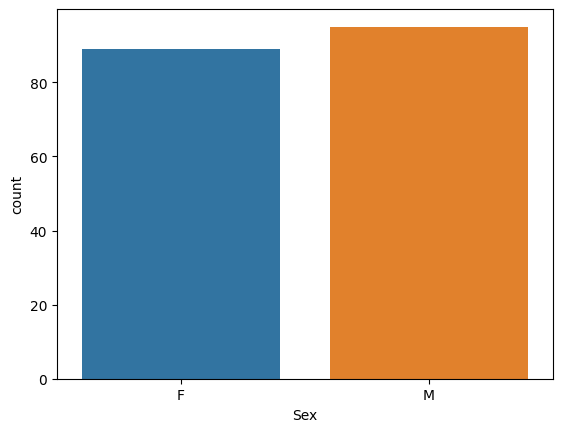

In [90]:
sns.countplot(x=df['Sex'])

In [91]:
df.Sex.value_counts()

M    95
F    89
Name: Sex, dtype: int64

In [92]:
df[df.Sex=='M'][df.Drug=='DrugY'].shape

/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(58, 6)

In [93]:
df[df.Sex=='F'][df.Drug=='DrugY'].shape

/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(56, 6)

In [94]:
df[df.Sex=='M'][df.Drug=='drugX'].shape

/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(37, 6)

In [95]:
df[df.Sex=='F'][df.Drug=='drugX'].shape

/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(33, 6)

<AxesSubplot:xlabel='Sex', ylabel='count'>

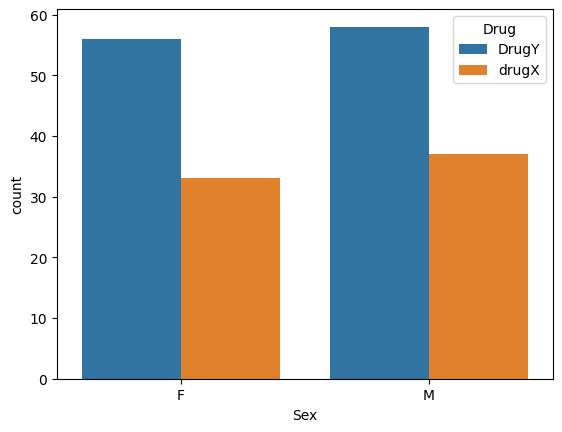

In [96]:
sns.countplot(data=df,x='Sex',hue='Drug')

In [97]:
df.BP.value_counts()

HIGH      77
NORMAL    59
LOW       48
Name: BP, dtype: int64

<AxesSubplot:xlabel='BP', ylabel='count'>

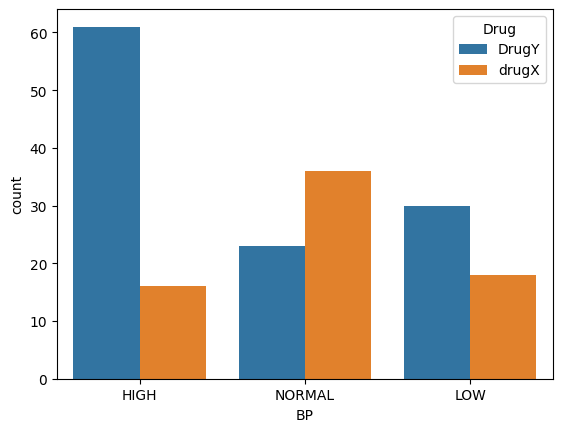

In [98]:
sns.countplot(data=df,x='BP',hue='Drug')

In [99]:
df.Cholesterol.value_counts()

NORMAL    97
HIGH      87
Name: Cholesterol, dtype: int64

<AxesSubplot:xlabel='Cholesterol', ylabel='count'>

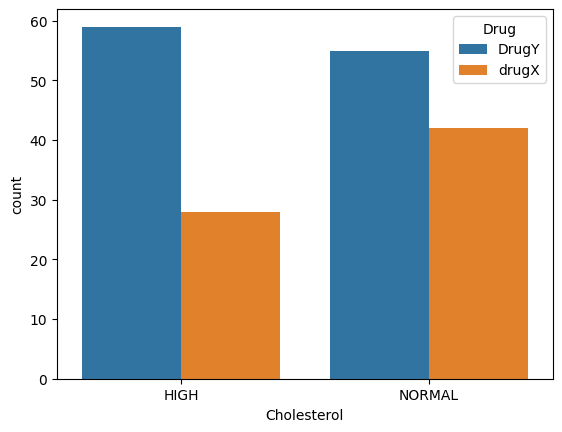

In [100]:
sns.countplot(data=df,x='Cholesterol',hue='Drug')

## Feature engineering

In [101]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [102]:
temp_df = pd.get_dummies(df[['Sex', 'BP', 'Cholesterol']])

In [103]:
temp_df

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,1,0,1,0,0,1,0
3,1,0,0,0,1,1,0
4,1,0,0,1,0,1,0
5,1,0,0,0,1,1,0
6,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...
192,0,1,0,1,0,1,0
194,1,0,1,0,0,1,0
197,0,1,0,0,1,1,0
198,0,1,0,0,1,0,1


In [104]:
df = temp_df.merge(df, left_index=True, right_index=True)

In [105]:
encoder = LabelEncoder()

In [106]:
df.Drug = encoder.fit_transform(df.Drug)

In [107]:
df

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,1,0,1,0,0,1,0,23,F,HIGH,HIGH,25.355,0
3,1,0,0,0,1,1,0,28,F,NORMAL,HIGH,7.798,1
4,1,0,0,1,0,1,0,61,F,LOW,HIGH,18.043,0
5,1,0,0,0,1,1,0,22,F,NORMAL,HIGH,8.607,1
6,1,0,0,0,1,1,0,49,F,NORMAL,HIGH,16.275,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,0,1,0,1,0,1,0,72,M,LOW,HIGH,16.310,0
194,1,0,1,0,0,1,0,46,F,HIGH,HIGH,34.686,0
197,0,1,0,0,1,1,0,52,M,NORMAL,HIGH,9.894,1
198,0,1,0,0,1,0,1,23,M,NORMAL,NORMAL,14.020,1


In [108]:
df = df.select_dtypes(exclude='object')

In [109]:
df

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age,Na_to_K,Drug
0,1,0,1,0,0,1,0,23,25.355,0
3,1,0,0,0,1,1,0,28,7.798,1
4,1,0,0,1,0,1,0,61,18.043,0
5,1,0,0,0,1,1,0,22,8.607,1
6,1,0,0,0,1,1,0,49,16.275,0
...,...,...,...,...,...,...,...,...,...,...
192,0,1,0,1,0,1,0,72,16.310,0
194,1,0,1,0,0,1,0,46,34.686,0
197,0,1,0,0,1,1,0,52,9.894,1
198,0,1,0,0,1,0,1,23,14.020,1


### Modeling

In [110]:
y = df['Drug']
X = df.drop('Drug', axis = 1)

In [112]:
X

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age,Na_to_K
0,1,0,1,0,0,1,0,23,25.355
3,1,0,0,0,1,1,0,28,7.798
4,1,0,0,1,0,1,0,61,18.043
5,1,0,0,0,1,1,0,22,8.607
6,1,0,0,0,1,1,0,49,16.275
...,...,...,...,...,...,...,...,...,...
192,0,1,0,1,0,1,0,72,16.310
194,1,0,1,0,0,1,0,46,34.686
197,0,1,0,0,1,1,0,52,9.894
198,0,1,0,0,1,0,1,23,14.020


In [113]:
y

0      0
3      1
4      0
5      1
6      0
      ..
192    0
194    0
197    1
198    1
199    1
Name: Drug, Length: 184, dtype: int64

In [114]:
x_train,x_test,y_train,y_test=train_test_split(X,y,
                             test_size=0.25,
                             random_state=100)

In [115]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(138, 9)
(46, 9)
(138,)
(46,)


In [116]:
print(y_train.mean())
print(y_test.mean())

0.38405797101449274
0.3695652173913043


In [127]:
def report(model,x_test,y_test):
    y_pred=model.predict(x_test)
    print("confusion matrix is :\n " ,metrics.confusion_matrix(y_test,y_pred))
    print("\n\nf1 score is :",metrics.f1_score(y_test,y_pred,average='macro'))
    print("\n\nrecall score is :",metrics.recall_score(y_test,y_pred))
    return

### XGBoost

In [133]:
XGB_model1 = XGBClassifier(n_estimators=300,max_depth=5)
XGB_model1.fit(x_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [134]:
report(XGB_model1,x_test,y_test)

confusion matrix is :
  [[29  0]
 [ 0 17]]


f1 score is : 1.0


recall score is : 1.0


### Logistic regression 

In [120]:
from sklearn.linear_model import LogisticRegression

In [121]:
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression()

In [129]:
report(log_reg,x_test,y_test)

confusion matrix is :
  [[28  1]
 [ 2 15]]


f1 score is : 0.9291217257318953


recall score is : 0.8823529411764706


### Randomforest classifier 


In [141]:
rfc=RandomForestClassifier(n_estimators=100,max_depth=3)

In [142]:
rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=3)

In [143]:
report(rfc,x_test,y_test)

confusion matrix is :
  [[29  0]
 [ 0 17]]


f1 score is : 1.0


recall score is : 1.0
